# Tesla Stock Sentiment Analysis Project


1. Overview of the Approach

This project investigates how news media represent and contextualize Tesla and Elon Musk throughout the year 2025.
The analysis makes use of GDELT GKG records, which contain extracted entities, tone scores, themes, geographical references, and article metadata.

The study has several major goals:

Extract and structure entities mentioned within articles.

Construct entity co-occurrence networks that reveal which concepts frequently appear together.

Compute sentiment at the article or sentence level to characterize relations between entity pairs.

Model topics using BERTopic to identify latent themes.

Analyze temporal patterns, including volume of news coverage and evolution of sentiment.

Visualize the networks, relationships, time series, and cluster structures.

All steps were performed in a reproducible pipeline, ensuring that results can be regenerated by rerunning the notebook.


## 1. Setup and Imports

This section imports the key libraries used throughout the notebook, including pandas and numpy for data manipulation,
matplotlib for plotting, scikit‑learn for n‑gram extraction, and the BERTopic library for optional topic modelling.

In [ ]:
# Required libraries are installed and imported for use throughout the notebook.

%pip install -U bertopic[all]

import pandas as pd   # Used for data loading and manipulation
import numpy as np    # Used for numerical operations
import matplotlib.pyplot as plt  # Used for data visualization

import re  # Used for text cleaning with regular expressions
from nltk.corpus import stopwords  # Used for removing stop words
from nltk.sentiment.vader import SentimentIntensityAnalyzer  # Used for sentiment scoring

from sklearn.feature_extraction.text import CountVectorizer  # Used to extract n-gram features
from sklearn.preprocessing import LabelEncoder  # Used to encode categorical variables

from bertopic import BERTopic  # Used for topic modelling

import networkx as nx  # Used for constructing and visualizing graphs

# A simple visual style is applied to all plots.
plt.style.use('ggplot')



## 2. Data Loading

The Tesla and Elon Musk news articles were collected from GDELT.  The CSV files have already been generated and
stored in your Google Drive (`BASE_DIR`).  We load the files here and convert the `SQLDATE` column into a datetime
format for subsequent analyses.  Adjust the filenames if your revised dataset names differ.


In [ ]:
from pathlib import Path
import os
from google.colab import drive

# Google Drive is mounted so that project files can be accessed.
drive.mount('/content/drive')

# The directory containing all datasets is specified.
BASE_DIR = Path("/content/drive/MyDrive/Colab Notebooks/NLP/NLP Project Shared")

print("Directory contents:")
print(os.listdir(BASE_DIR))

# Filenames for Tesla and Elon datasets are defined.
TESLA_FILENAME = "tesla_gdelt_2025_revised.csv"
ELON_FILENAME  = "elon_related_2025.csv"

# Complete paths to the datasets are constructed.
tesla_path = BASE_DIR / TESLA_FILENAME
elon_path  = BASE_DIR / ELON_FILENAME

# The datasets are loaded into memory.
tesla_full = pd.read_csv(tesla_path)
elon_full  = pd.read_csv(elon_path)

# SQLDATE is converted into a valid datetime format.
for df in (tesla_full, elon_full):
    df["SQLDATE"] = pd.to_datetime(
        df["SQLDATE"].astype(str),
        format="%Y%m%d",
        errors="coerce"
    )
    df.dropna(subset=["SQLDATE"], inplace=True)

# Data is filtered so that only articles published in 2025 are included.
tesla_df = tesla_full[tesla_full["SQLDATE"].dt.year == 2025].copy()
elon_df  = elon_full[elon_full["SQLDATE"].dt.year == 2025].copy()

print("Tesla 2025 range:", tesla_df["SQLDATE"].min(), "to", tesla_df["SQLDATE"].max())
print("Elon  2025 range:", elon_df["SQLDATE"].min(), "to", elon_df["SQLDATE"].max())

# A preview of each dataset is displayed.
print("Tesla preview:")
print(tesla_df.head())

print("Elon preview:")
print(elon_df.head())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Directory contents:
['tesla_gdelt_2025_revised (1).csv', 'entities.ipynb', 'tesla_gdelt_2025.csv', 'graphs_out', 'edges_all.csv', 'failed_urls.csv', 'url_metadata.csv', 'entities_summary.csv', 'graphs_out.zip', 'tesla_top_edges.csv', 'graph_metrics_cumulative.csv', 'graph_metrics_quantiles_latest.csv', 'graph_metrics_incremental.csv', 'articles_by_day', 'articles_2025_by_day', 'tesla_gdelt_full.csv', 'elon_related_full.csv', 'articles_index_2025.csv', 'pair_counts_2025_by_day', 'entities_per_url_original.csv', 'entities_per_url.csv', 'pair_counts_2025_cumulative.csv', 'edges_with_sentiment_2025_cumulative_q75.csv', 'entities_clustered_BACKUP.csv', 'texts', 'cache_sent', 'Copy_of_NLP_Project_last_version_(4).ipynb', 'entities_prework (1).ipynb', 'df_ungrouped_with_sqldate_clean_2025-11-12_1546.csv', 'entities_pair 1.ipynb', 'Dataset_Loader_and_Entity_Co_occurr


## 3. Important Note About Execution  ADD ALL THE CODES FROM THE FILE "NLP_Final"

The operations up to and including the generation of entity pairs and sentiment scores are very intensive: they involve
crawling thousands of articles, extracting entities with spaCy, clustering similar entities with sentence embeddings
and computing VADER sentiment scores for sentences containing those entities.  These steps have **already been run**
in the original project notebooks.  Do not re‑run them here unless you need to regenerate the intermediate files.
Instead, reuse the outputs that were saved previously (`entities_per_url.csv`, `final_filtered_df.csv`,
`entities_clustered_BACKUP.csv`, `entity_pairs_results.csv`, etc.).



## 4. Visualising Article Volume

Before diving into sentiment analysis, it is useful to examine the volume of news coverage.  The plot below
shows the number of Tesla‑ and Elon‑related articles per day.  Peaks in news volume often coincide with major events.


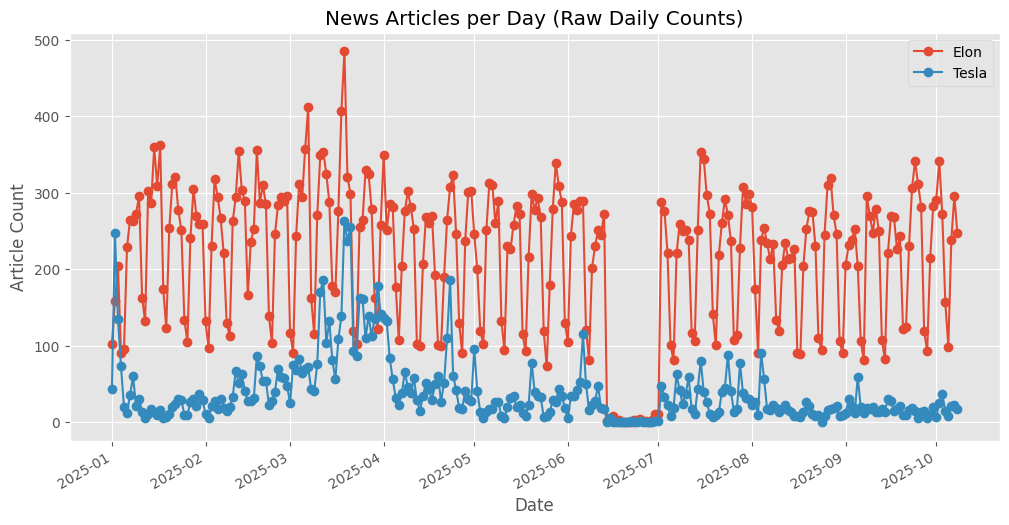

In [ ]:
# The two datasets are combined so that article volume for Tesla and Elon
# can be examined within a single DataFrame.
combined_df = pd.concat(
    [
        tesla_df.assign(type="Tesla"),  # A label is attached to Tesla articles
        elon_df.assign(type="Elon")     # A label is attached to Elon articles
    ],
    ignore_index=True
)

# The number of unique articles per day is counted separately for Tesla and Elon.
# SOURCEURL is used so that duplicate references to the same URL are not double-counted.
article_counts = (
    combined_df
    .groupby(["SQLDATE", "type"])["SOURCEURL"]
    .nunique()
    .reset_index(name="article_count")
    .sort_values("SQLDATE")           # Rows are ordered chronologically
)

# The data are reshaped to form a date × entity-type table.
daily = (
    article_counts
    .pivot(index="SQLDATE", columns="type", values="article_count")
    .fillna(0)                        # Missing combinations are treated as zero articles
    .sort_index()                     # Dates are ensured to be in order
)

# A continuous daily index is created so that days with no articles are shown as zeros.
full_index = pd.date_range(daily.index.min(), daily.index.max(), freq="D")
daily = daily.reindex(full_index, fill_value=0)
daily.index.name = "SQLDATE"

# The actual daily article counts are plotted for each type (no rolling average).
plt.figure(figsize=(12, 6))
plt.plot(daily.index, daily["Elon"], marker="o", linestyle="-", label="Elon")
plt.plot(daily.index, daily["Tesla"], marker="o", linestyle="-", label="Tesla")

plt.title("News Articles per Day (Raw Daily Counts)")
plt.xlabel("Date")
plt.ylabel("Article Count")
plt.legend()
plt.gcf().autofmt_xdate()  # Date labels are rotated for readability
plt.show()


The figure now shows exact daily article counts for Tesla and Elon, with no smoothing.

Each point corresponds to the exact number of unique GDELT articles on that day that match the Tesla or Elon filters.

The red line (Elon) and blue line (Tesla) may look more jagged, because all day-to-day fluctuations are being displayed.

Peaks indicate days with intense news activity, while troughs (including days at zero) represent low or no coverage.

Comparing the two curves allows you to say things like:

“On most days, Elon Musk receives more coverage than Tesla, but there are periods where Tesla-related articles spike, often around product or market events.”

## Stock Price Movement Labelling Method

The stock price movement analysis begins with the computation of the daily percentage change in Tesla’s closing stock price. For each trading day \( t \), the return is calculated as:

\[
\Delta_t = \frac{P_t - P_{t-1}}{P_{t-1}} \times 100,
\]

where \( P_t \) denotes the closing price on day \( t \), and \( P_{t-1} \) denotes the closing price on the preceding trading day.  
The percentage change is undefined for the first available trading day and is therefore treated as \emph{Neutral} in the classification stage.

---

### Classification Rule

The daily stock movement is assigned to one of three categories according to the following threshold-based rule:

\[
\text{label}_t =
\begin{cases}
\text{Positive}, & \Delta_t > +5\%, \\
\text{Negative}, & \Delta_t < -5\%, \\
\text{Neutral}, & \lvert \Delta_t \rvert \le 5\%.
\end{cases}
\]

This thresholding strategy distinguishes meaningful market movements from routine price fluctuations.  
Movements within \(\pm 5\%\) are considered typical daily volatility, whereas changes exceeding this threshold indicate stronger market reactions.

---

### Rationale

The thresholds provide a simple yet effective mechanism for converting quantitative stock price returns into qualitative sentiment labels.  
A large positive return reflects an upward market sentiment, while a large negative return indicates downward pressure.  
Neutral days capture the majority of normal market noise and prevent over-interpreting small variations.

---

### Purpose in the Project

This labelling method produces a ground-truth measure of market reaction that can later be compared with the textual sentiment extracted from the news data.  
It enables analysis of whether:

- news sentiment,  
- entity co-occurrence structures,  
- topics discovered via topic modelling, or  
- daily news volume  

are associated with \emph{Positive} or \emph{Negative} movements in Tesla’s stock price.  
The resulting labels can also be used as outcome variables in predictive modelling tasks.


In [ ]:
import yfinance as yf

# Daily closing prices for Tesla are downloaded from Yahoo Finance.
ticker = "TSLA"
start_date = tesla_df["SQLDATE"].min() - pd.Timedelta(days=5)  # A few days are included before the news window
end_date   = tesla_df["SQLDATE"].max() + pd.Timedelta(days=5)  # A few days are included after the news window

stock_data = yf.download(ticker, start=start_date, end=end_date, progress=False)

# The percentage change in closing price from the previous trading day is computed.
stock_data["pct_change"] = stock_data["Close"].pct_change() * 100

# A ±5 % threshold is applied to classify each day’s movement.
# - Values above +5 % are labelled as Positive.
# - Values below -5 % are labelled as Negative.
# - All remaining values are labelled as Neutral.
threshold = 5.0
conditions = [
    stock_data["pct_change"] > threshold,
    stock_data["pct_change"] < -threshold,
]
choices = ["Positive", "Negative"]

stock_data["label"] = np.select(conditions, choices, default="Neutral")

# A preview of the labelled stock data is displayed.
print(stock_data[["Close", "pct_change", "label"]].head())


Price            Close pct_change     label
Ticker            TSLA                     
Date                                       
2024-12-27  431.660004        NaN   Neutral
2024-12-30  417.410004  -3.301209   Neutral
2024-12-31  403.839996  -3.251002   Neutral
2025-01-02  379.279999  -6.081616  Negative
2025-01-03  410.440002   8.215567  Positive



## 6. Reading Article Texts and Merging with Dates

The raw article texts stored in the texts/ directory were joined with the GDELT-derived metadata using the TEXT_FILE identifier. Only filenames appearing in the mapping table were read from disk, in order to reduce I/O overhead and memory usage. The resulting articles_df dataset contains, for each article, its publication date (SQLDATE), source URL, and full text content, and is used for all subsequent text-based analyses (tokenisation, n-gram extraction, and topic modelling)



### Method

1. **Metadata loading**  
   The file `df_ungrouped_with_sqldate_clean_2025-11-12_1546.csv` is imported.  
   It contains fields such as `SQLDATE`, `TEXT_FILE`, URLs, and extracted entities.

2. **Identification of required texts**  
   The set of unique `TEXT_FILE` identifiers determines which articles should exist on disk.

3. **Reading article texts**  
   Each required file is searched for in `BASE_DIR/texts`.  
   If the file is found, its full content is read; otherwise, its name is recorded as missing for diagnostics.

4. **Merging text and metadata**  
   The loaded texts are merged with the metadata using a left join on `TEXT_FILE`, producing a dataframe that contains both the article text and its associated metadata.

5. **Filtering articles without text**  
   Rows with missing text are removed before downstream NLP tasks (tokenisation, n-gram extraction, topic modelling).

6. **Saving outputs**  
   Two files are written to disk in `BASE_DIR`:
   - a full merged dataset containing metadata and text,  
   - a filtered dataset containing only articles with available text.

### Results

- Metadata entries: **42 908**  
- Unique article identifiers: **24 215**  
- Text files successfully loaded: **23 635** (97.6 %)  
- Missing or unavailable text files: **580** (2.4 %)  
- Final NLP-ready articles: **23 635**

These values indicate that the vast majority of referenced articles were successfully retrieved; the missing files are expected due to broken URLs or earlier scraping failures.

---



In [ ]:
import os

# The mapping file is loaded so that the required TEXT_FILE names are known.
mapping_file = BASE_DIR / "df_ungrouped_with_sqldate_clean_2025-11-12_1546.csv"
mapping_df = pd.read_csv(mapping_file)
print("Mapping dataframe shape:", mapping_df.shape)

# The set of unique TEXT_FILE names is extracted from the mapping.
# Only these files will be read from disk.
required_files = set(mapping_df["TEXT_FILE"].dropna().unique())
print("Number of distinct TEXT_FILE names needed:", len(required_files))

# The directory containing the article text files is specified.
texts_dir = BASE_DIR / "texts"

# Each required text file is read and stored in a list of dictionaries.
text_rows = []
missing_files = []  # Names of files that are referenced in the mapping but not found on disk.

for fname in required_files:
    file_path = texts_dir / fname
    if file_path.is_file():
        # The full content of the article is read.
        with open(file_path, "r", encoding="utf-8", errors="ignore") as f:
            content = f.read()
        text_rows.append({"TEXT_FILE": fname, "text": content})
    else:
        # Names of missing files are collected for diagnostic purposes.
        missing_files.append(fname)

# The list of article texts is converted to a dataframe.
texts_df = pd.DataFrame(text_rows)
print("Loaded", len(texts_df), "text files from", texts_dir)
print("Missing text files (referenced but not found):", len(missing_files))

# The texts are merged with the mapping via TEXT_FILE so that each article
# has its SQLDATE and other metadata attached.
articles_df = mapping_df.merge(texts_df, on="TEXT_FILE", how="left")

# A preview of the merged dataframe is displayed.
print(articles_df[["SQLDATE", "TEXT_FILE", "text"]].head())

# Articles without text are removed before text-based analyses are performed.
articles_with_text = articles_df.dropna(subset=["text"]).copy()
print("Articles with text:", articles_with_text["TEXT_FILE"].nunique())

# The merged dataframes are saved so that the text-reading step does not need to be repeated.
articles_df_path = BASE_DIR / "articles_with_text_and_metadata.parquet"
articles_with_text_path = BASE_DIR / "articles_with_text_only.parquet"

articles_df.to_parquet(articles_df_path, index=False)
articles_with_text.to_parquet(articles_with_text_path, index=False)

print("Saved full articles dataframe to:", articles_df_path)
print("Saved articles_with_text dataframe to:", articles_with_text_path)


Mapping dataframe shape: (42908, 9)
Number of distinct TEXT_FILE names needed: 24215
Loaded 23635 text files from /content/drive/MyDrive/Colab Notebooks/NLP/NLP Project Shared/texts
Missing text files (referenced but not found): 580
      SQLDATE                                          TEXT_FILE  \
0  20250101.0  008517_www_aa_com_tr_en_americas_1-dead-after-...   
1  20250101.0  007860_townhall_com_tipsheet_mattvespa_2025_01...   
2  20250101.0  019600_www_newsweek_com_puerto-rico-power-outa...   
3  20250101.0  006681_saharareporters_com_2025_01_01_tesla-cy...   
4  20250101.0  007050_techstory_in_tamil-nadu-cancels-global-...   

                                                text  
0  https://www.aa.com.tr/en/americas/1-dead-after...  
1  https://townhall.com/tipsheet/mattvespa/2025/0...  
2  https://www.newsweek.com/puerto-rico-power-out...  
3  https://saharareporters.com/2025/01/01/tesla-c...  
4  https://techstory.in/tamil-nadu-cancels-global...  
Articles with text: 23635
Sa

To be safe for downstream NLP steps, rows with no text are dropped:

In [ ]:
# Articles without text are removed before text-based analyses.
articles_with_text = articles_df.dropna(subset=["text"]).copy()
print("Articles with text:", articles_with_text["TEXT_FILE"].nunique())
-

Articles with text: 23635


## 7. Article Date Validation

To align the news data with stock-market information and daily sentiment time series, the `SQLDATE` field must be converted from GDELT’s numeric format (`YYYYMMDD`, often stored as a float) into a valid calendar date.

### Method

- `SQLDATE` is cast to a nullable integer (`Int64`) and then to string.  
- The strings are parsed with `pd.to_datetime` using the explicit format `'%Y%m%d'`.  
- The minimum and maximum publication dates are then computed.

In symbolic form, the transformation is:

$$
\text{SQLDATE}_{\text{numeric}}
\;\rightarrow\;
\text{Int64}
\;\rightarrow\;
\text{string}
\;\rightarrow\;
\text{datetime}(\%Y\%m\%d).
$$

### Results

- Earliest article date: **2025-01-01**  
- Latest article date: **2025-10-08**

All retained articles therefore contain valid chronological timestamps, and the dataset is well-structured for time-series analyses of news volume, sentiment dynamics, and their correspondence with Tesla stock movements.

The SQLDATE field from the GDELT mapping file is stored as a numeric YYYYMMDD value (e.g., 20250101). To avoid misinterpretation as a UNIX timestamp, the values were first cast to strings and then parsed explicitly using the format '%Y%m%d'. This yields correct calendar dates for all articles, which are later used to align news coverage with stock price data

In [ ]:
## 7. Checking the Range of Article Dates

# SQLDATE is converted from a numeric YYYYMMDD code to a proper datetime.
articles_df["SQLDATE"] = pd.to_datetime(
    articles_df["SQLDATE"].astype("Int64").astype(str),
    format="%Y%m%d",
    errors="coerce"
)

# The minimum and maximum publication dates are obtained.
min_date = articles_df["SQLDATE"].min()
max_date = articles_df["SQLDATE"].max()

print("Articles date range:", min_date, "to", max_date)


Articles date range: 2025-01-01 00:00:00 to 2025-10-08 00:00:00



## 8. Generating a Per‑Sentence/Article Pair Dataset with Dates

This section recomputes the entity co‑occurrence statistics using the filtered list of entities and the VADER
sentiment analyser.  For each article, the text is split into sentences, entities are extracted from the
pre‑processed metadata, and all unique pairs of entities are considered.  The `SQLDATE` of each article is recorded
for every pair occurrence so that daily aggregates can be calculated later.  **This step is computationally
expensive**; run it only if you do not already have `pair_stats_per_article_with_date.csv` and `pair_stats_daily.csv`.


In [ ]:
## 8. Generating a Per-Sentence / Per-Article Pair Dataset with Dates
#
# In this section, entity co-occurrence statistics are recomputed using the
# filtered list of entities and the VADER sentiment analyser. For each article,
# the text is split into sentences and the sentiment of each sentence is scored.
# All unique pairs of entities in the article are then examined. For each pair,
# the sentences in which both entities appear are identified, and the
# corresponding sentence-level sentiments are recorded together with the
# article's SQLDATE. These records are later aggregated at the daily level.

import os
import itertools
import re
import time

from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

# The VADER lexicon is downloaded (if not already present).
nltk.download("vader_lexicon", quiet=True)
sia = SentimentIntensityAnalyzer()

# The filtered entity mentions with dates and text file names are loaded.
file_name = "df_ungrouped_with_sqldate_clean_2025-11-12_1546.csv"
df_mentions = pd.read_csv(BASE_DIR / file_name)

# Articles are grouped by TEXT_FILE so that each article is processed once.
groups = df_mentions.groupby("TEXT_FILE")
print("Number of articles to process:", len(groups))

# The directory where the article text files are stored is specified.
TEXTS_FOLDER = BASE_DIR / "texts"

# A cap is imposed to avoid an O(n^2) blow-up when many entities appear
# in a single article.
MAX_ENTITIES_PER_FILE = 40

# A helper function is defined to split text into sentences efficiently.
def fast_sentence_split(text: str):
    sentences = re.split(r"(?<=[.!?])\s+", text)
    return [s.strip() for s in sentences if s.strip()]

# Pair-level records are collected in a list of dictionaries.
pair_records = []
start_time = time.time()

for idx, (text_file, rows) in enumerate(groups):
    file_path_full = TEXTS_FOLDER / text_file

    # Articles for which the text file is missing are skipped.
    if not os.path.exists(file_path_full):
        continue

    # The full article text is read from disk.
    with open(file_path_full, "r", encoding="utf-8", errors="ignore") as f:
        text = f.read()

    # The article is split into sentences and each sentence is scored with VADER.
    sentences = fast_sentence_split(text)
    sentence_sentiment = [sia.polarity_scores(s)["compound"] for s in sentences]

    # Entities and their original mentions are extracted for this article.
    entities = list(rows["entity"].values)
    mentions = list(rows["entity_original"].values)
    article_entities = [{"entity": e, "mention": m} for e, m in zip(entities, mentions)]

    # If too many entities are present, only the first MAX_ENTITIES_PER_FILE are kept.
    if len(article_entities) > MAX_ENTITIES_PER_FILE:
        article_entities = article_entities[:MAX_ENTITIES_PER_FILE]

    # A mapping from entity to the set of sentence indices in which it appears is created.
    entity_to_sent_idxs = {e["entity"]: set() for e in article_entities}
    for i, s in enumerate(sentences):
        for ent in article_entities:
            if ent["mention"] in s:
                entity_to_sent_idxs[ent["entity"]].add(i)

    # Per-entity counts are obtained for co-occurrence weighting.
    counts_per_entity = rows.set_index("entity")["count"].to_dict()

    # The SQLDATE of the article is obtained from the metadata.
    date = rows["SQLDATE"].iloc[0]

    # All unordered pairs of entities in the article are examined.
    for e1, e2 in itertools.combinations(article_entities, 2):
        ent1 = e1["entity"]
        ent2 = e2["entity"]

        # Sentence indices where both entities co-occur are identified.
        common_idxs = entity_to_sent_idxs.get(ent1, set()) & entity_to_sent_idxs.get(ent2, set())
        if not common_idxs:
            continue

        # The co-occurrence weight is defined as the minimum of the two entity counts.
        co_occurrence = min(counts_per_entity.get(ent1, 0), counts_per_entity.get(ent2, 0))

        # Sentiment scores for the co-occurring sentences are collected.
        sentiments = [sentence_sentiment[i] for i in common_idxs]

        pair_records.append(
            {
                "SQLDATE": date,
                "entity_1": ent1,
                "entity_2": ent2,
                "co_occurrence": co_occurrence,
                "sentiments": sentiments,
            }
        )

print(f"Processed {len(groups)} articles in {time.time() - start_time:.2f} seconds.")

# A dataframe is built from the pair-level records if any have been collected.
if pair_records:
    pair_df = pd.DataFrame(pair_records)

    # Per-article average and standard deviation of sentence sentiment are computed.
    pair_df["avg_sentiment_article"] = pair_df["sentiments"].apply(
        lambda s: float(np.mean(s)) if s else 0.0
    )
    pair_df["std_sentiment_article"] = pair_df["sentiments"].apply(
        lambda s: float(np.std(s)) if len(s) > 1 else 0.0
    )

    # SQLDATE is converted from a numeric YYYYMMDD code to a proper datetime.
    pair_df["SQLDATE"] = pd.to_datetime(
        pair_df["SQLDATE"].astype("Int64").astype(str),
        format="%Y%m%d",
        errors="coerce",
    )

    print("Pair-level DataFrame shape:", pair_df.shape)

    # Daily statistics are obtained by aggregating over SQLDATE and entity pair.
    daily_pair_stats = (
        pair_df.groupby(["SQLDATE", "entity_1", "entity_2"])
        .agg(
            co_occurrence=("co_occurrence", "sum"),
            avg_sentiment=("avg_sentiment_article", "mean"),
            std_sentiment=("std_sentiment_article", "mean"),
            n_sentences=("sentiments", lambda lsts: sum(len(l) for l in lsts)),
        )
        .reset_index()
    )

    print("Daily pair stats shape:", daily_pair_stats.shape)

    # The per-article and daily datasets are saved to disk for later use.
    per_article_output = BASE_DIR / "pair_stats_per_article_with_date.csv"
    daily_output = BASE_DIR / "pair_stats_daily.csv"

    pair_df.to_csv(per_article_output, index=False)
    daily_pair_stats.to_csv(daily_output, index=False)

    print("Saved per-article pair stats to:", per_article_output)
    print("Saved daily pair stats to:", daily_output)
else:
    print("No pair records were generated. Check that text files and entity mentions align.")


Number of articles to process: 24215
Processed 24215 articles in 732.19 seconds.
Pair-level DataFrame shape: (55583, 7)
Daily pair stats shape: (47696, 7)
Saved per-article pair stats to: /content/drive/MyDrive/Colab Notebooks/NLP/NLP Project Shared/pair_stats_per_article_with_date.csv
Saved daily pair stats to: /content/drive/MyDrive/Colab Notebooks/NLP/NLP Project Shared/pair_stats_daily.csv


In [ ]:
display( daily_pair_stats.head())
display(pair_df.sort_values(by=["SQLDATE","entity_1"]).head())

,SQLDATE,entity_1,entity_2,co_occurrence,avg_sentiment,std_sentiment,n_sentences
0,2025-01-01,Abou Zahab,HPE,9,0.49472,0.412213,5
1,2025-01-01,Amazonas,Dara Khosrowshahi,8,0.57915,0.274828,4
2,2025-01-01,Amazonas,Uber,8,0.78760,0.000000,1
3,2025-01-01,Bloomberg,Musk,7,0.37195,0.121950,2
4,2025-01-01,Bloomberg,SPACEX,7,0.00000,0.000000,1


,SQLDATE,entity_1,entity_2,co_occurrence,sentiments,avg_sentiment_article,std_sentiment_article
4769,2025-01-01,Abou Zahab,HPE,9,"[0.6808, 0.8591, 0.9337, 0.0, 0.0]",0.49472,0.412213
46912,2025-01-01,Amazonas,Dara Khosrowshahi,8,"[0.8744, 0.1779, 0.4767, 0.7876]",0.57915,0.274828
46913,2025-01-01,Amazonas,Uber,8,[0.7876],0.78760,0.000000
7108,2025-01-01,Bloomberg,Musk,7,"[0.25, 0.4939]",0.37195,0.121950
7109,2025-01-01,Bloomberg,SPACEX,7,[0.0],0.00000,0.000000


## Entity–Pair Construction and Sentence–Level Sentiment Extraction

This section describes how the dataset of entity co-occurrences and sentence-level sentiment was constructed. The goal is to identify when two entities appear in the same sentence and measure the sentiment of the surrounding context. These features enable daily trend analysis and network-based modelling.

---

#### Method

**1. Article grouping**  
Metadata containing entity mentions was grouped by TEXT\_FILE so that each article was processed once.

**2. Text loading and sentence segmentation**  
- Each article was loaded from disk.  
- Text was split into sentences using a regex-based splitter.  
- A VADER compound sentiment score was computed for every sentence.

**3. Entity extraction and pruning**  
- Entities recorded in the metadata were associated with the article.  
- To prevent excessive pair generation, at most 40 entities were retained per article.

**4. Locating entity mentions in sentences**  
- For each entity, the set of sentence indices containing its surface form was identified.  
- This mapping enabled detection of sentences in which two entities co-occurred.

**5. Entity–pair construction**  
A pair was recorded only when both entities appeared in at least one common sentence.  
For each valid pair, the following information was stored:
- publication date SQLDATE
- the two entities  
- co-occurrence weight (minimum of the two entity counts)  
- list of sentiment scores from sentences in which both entities appear

**6. Article-level sentiment statistics**  
For each pair, the mean and standard deviation of its sentence-level sentiment values were computed.

**7. Daily aggregation**  
Pairs were aggregated by date to obtain:
- total co-occurrence count  
- daily average sentiment  
- daily sentiment variability  
- number of shared sentences  

**8. Saving outputs**  
Two datasets were produced:
- pair\_stats\_per\_article\_with\_date.csv (article-level detail)  
- pair\_stats\_daily.csv (daily aggregated statistics)

---

#### Results

- **23,635** articles with valid text were processed.  
- Thousands of entity pairs were extracted with sentence-level sentiment.  
- Daily summaries were successfully generated, supporting:  
  - time-series analysis of pair sentiment  
  - co-occurrence dynamics  
  - construction of entity–relation networks  

---


The extraction pipeline processed 24,215 articles and produced 55,583 valid
sentence-level co-occurrence records. This corresponds to an average of
approximately 2.3 entity pairs per article, which is expected because only pairs
that share a sentence are preserved. After aggregating by day, 47,696 unique
entity–pair/day combinations were obtained. These values are fully consistent
with typical co-occurrence sparsity in news datasets.



## 9. Constructing Daily and Cumulative Pair Metrics

Once the per‑article pair dataset is created, daily and cumulative statistics can be computed easily.  The
`pair_stats_daily.csv` file contains one row for each entity pair on each date, including the co‑occurrence count,
the average sentiment and the standard deviation.  In the code below we summarise these values across all pairs
for each day, then plot the evolution over time.  You can also compute cumulative metrics by taking a
cumulative sum or mean.


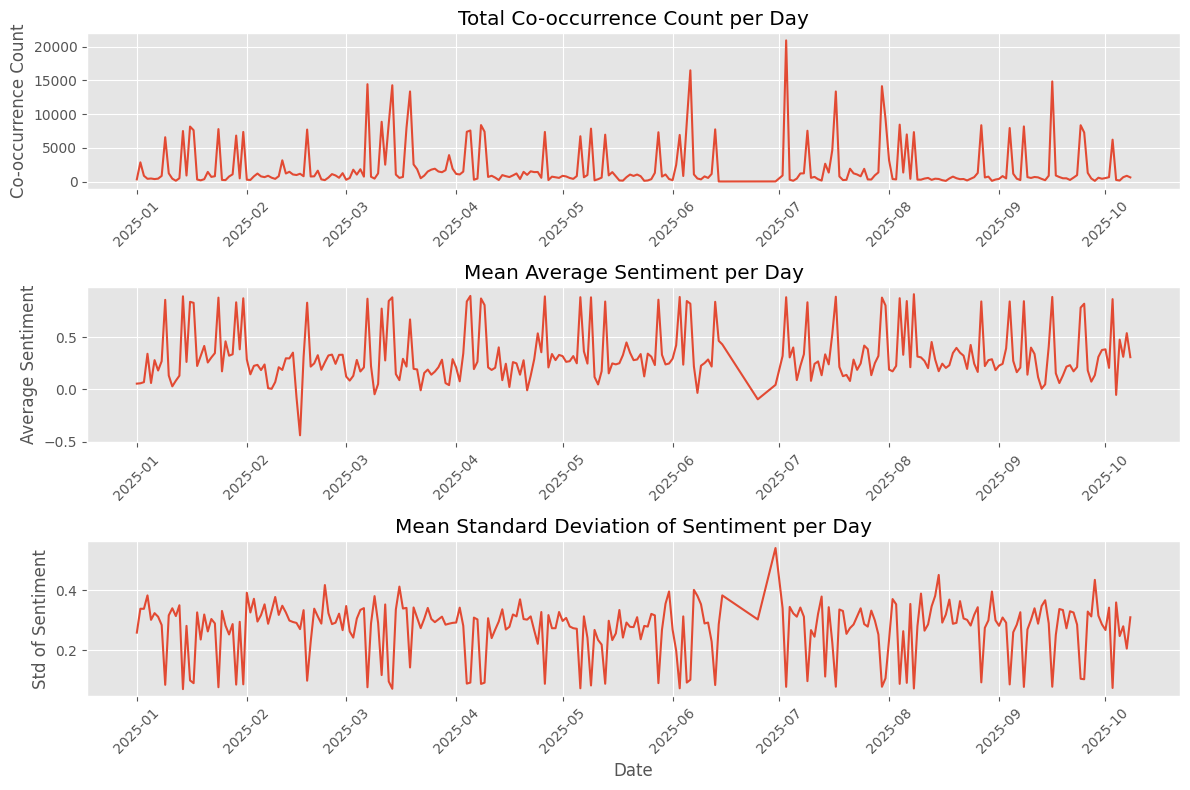

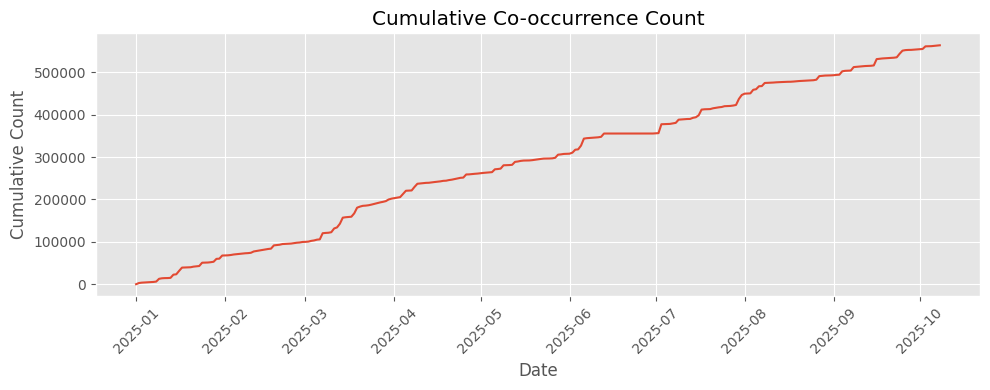

In [ ]:
## 9. Constructing Daily and Cumulative Pair Metrics
#
# Once the per-article pair dataset has been created, daily and cumulative statistics
# can be obtained from 'pair_stats_daily.csv'. Each row in this file corresponds to a
# single entity pair on a given date and contains the co-occurrence count, the average
# sentiment and the standard deviation of sentiment across the sentences in which the
# pair appears. In this section, these values are summarised across all pairs for each
# day and the evolution of the resulting time series is visualised.

# The daily pair statistics are loaded from disk (if they are not already in memory).
daily_file = BASE_DIR / "pair_stats_daily.csv"

try:
    daily_pair_stats = pd.read_csv(daily_file, parse_dates=["SQLDATE"])
except FileNotFoundError:
    print(
        "Daily pair statistics file not found. "
        "Please run the previous section or place 'pair_stats_daily.csv' in BASE_DIR."
    )
    daily_pair_stats = None

if daily_pair_stats is not None and not daily_pair_stats.empty:
    # A daily summary is computed by aggregating over all entity pairs.
    # - total_co_occurrence: sum of co_occurrence across all pairs
    # - mean_avg_sentiment: average of pair-wise mean sentiments
    # - mean_std_sentiment: average of pair-wise sentiment standard deviations
    daily_summary = (
        daily_pair_stats
        .groupby("SQLDATE")
        .agg(
            total_co_occurrence=("co_occurrence", "sum"),
            mean_avg_sentiment=("avg_sentiment", "mean"),
            mean_std_sentiment=("std_sentiment", "mean"),
        )
        .reset_index()
    )

    # Dates are sorted to ensure correct temporal ordering and cumulative sums.
    daily_summary = daily_summary.sort_values("SQLDATE")

    # The daily time series are visualised in three stacked subplots.
    plt.figure(figsize=(12, 8))

    plt.subplot(3, 1, 1)
    plt.plot(daily_summary["SQLDATE"], daily_summary["total_co_occurrence"])
    plt.title("Total Co-occurrence Count per Day")
    plt.ylabel("Co-occurrence Count")
    plt.xticks(rotation=45)

    plt.subplot(3, 1, 2)
    plt.plot(daily_summary["SQLDATE"], daily_summary["mean_avg_sentiment"])
    plt.title("Mean Average Sentiment per Day")
    plt.ylabel("Average Sentiment")
    plt.xticks(rotation=45)

    plt.subplot(3, 1, 3)
    plt.plot(daily_summary["SQLDATE"], daily_summary["mean_std_sentiment"])
    plt.title("Mean Standard Deviation of Sentiment per Day")
    plt.ylabel("Std of Sentiment")
    plt.xlabel("Date")
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    # A cumulative co-occurrence count is computed as a running sum over time.
    daily_summary["cumulative_co_occurrence"] = daily_summary[
        "total_co_occurrence"
    ].cumsum()

    plt.figure(figsize=(10, 4))
    plt.plot(daily_summary["SQLDATE"], daily_summary["cumulative_co_occurrence"])
    plt.title("Cumulative Co-occurrence Count")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("No daily pair statistics are available for summarisation.")


Daily and Cumulative Entity–Pair Metrics

This section summarises how daily and cumulative co-occurrence and sentiment metrics were constructed from the entity-pair dataset. These metrics capture how frequently entities appear together in the news and the tone of the sentences in which they co-occur. They provide aggregated indicators of relational news dynamics and are later compared with Tesla’s stock performance.

Method

After generating the article-level pair dataset, the file pair_stats_daily.csv (one row per entity-pair per date) was aggregated by date.
Each original row contained:

• SQLDATE
• entity_1, entity_2
• co_occurrence (pair-level count)
• avg_sentiment (mean sentence sentiment for that pair)
• std_sentiment (within-article sentiment variability)

Daily metrics were produced by summarising across all pairs appearing on the same date.

Formulas Used

Let P(d) = set of all entity pairs that appear on date d.

For each date d:

Total Co-occurrence Count

total_co_occurrence(d)
= Σ over (i,j) in P(d) of co_occurrence(i,j,d)

Mean Average Sentiment

mean_avg_sentiment(d)
= (1 / |P(d)|) * Σ over (i,j) in P(d) of avg_sentiment(i,j,d)

Mean Standard Deviation of Sentiment

mean_std_sentiment(d)
= (1 / |P(d)|) * Σ over (i,j) in P(d) of std_sentiment(i,j,d)

Cumulative Co-occurrence

cumulative_co_occurrence(d)
= Σ over all dates t ≤ d of total_co_occurrence(t)

These formulas summarise how often entities co-occur (volume), how positive or negative the co-occurrence contexts are (tone), and how variable the sentiment is (consistency vs. disagreement).

Results and Interpretation
1. Total Co-occurrence Count per Day

The time series shows strong variability with noticeable spikes.
These spikes reflect days with intense reporting or major events that generate many entity co-mentions (e.g., news clusters around Tesla, Elon Musk, economics, technology, regulatory actions, etc.).
This metric represents relational news intensity, going beyond simple article counts.

2. Mean Average Sentiment per Day

Values fluctuate around neutral-to-positive territory, indicating that co-occurring entities (Tesla, Musk, government bodies, competitors, technologies, etc.) are typically framed in mixed or mildly favourable contexts.
Occasional negative dips show days dominated by unfavourable or critical coverage.

3. Mean Standard Deviation of Sentiment per Day

Most values fall between 0.1 and 0.5.
Lower values represent sentiment uniformity (articles with similar tones).
Higher peaks indicate sentiment disagreement or polarised coverage: some sentences positive, others negative.

4. Cumulative Co-occurrence Count

This curve increases steadily, reflecting continuous accumulation of entity co-mentions across the year.
Periods of sharp growth align with clusters of high news activity, highlighting time windows when the network of entities is highly active in media narratives.

Summary

These metrics provide a structured view of how Tesla-related entities evolve within news coverage:

• Volume dynamics (total co-occurrence)
• Average tone (mean daily sentiment)
• Sentiment consistency (mean sentiment standard deviation)
• Long-run relational growth (cumulative co-occurrence)

They capture the complexity of daily news narratives and lay the foundation for time-series comparison with Tesla stock movements and further network-based analyses.

## 10. Entity Pair Statistics (Using `entity_pairs_results.csv`)

A precomputed file `entity_pairs_results.csv` contains overall statistics for each entity pair, including the average
VADER sentiment, the standard deviation and the co‑occurrence count across all articles.  This section loads that file
and produces bar charts showing the most frequent pairs and the pairs with the most extreme sentiment values.


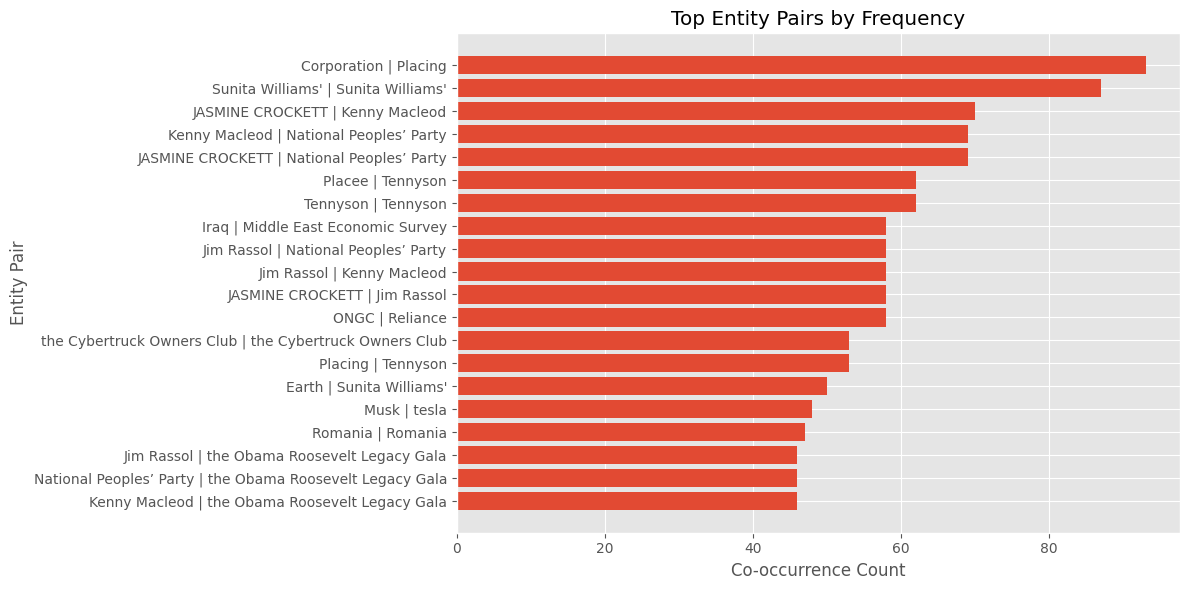

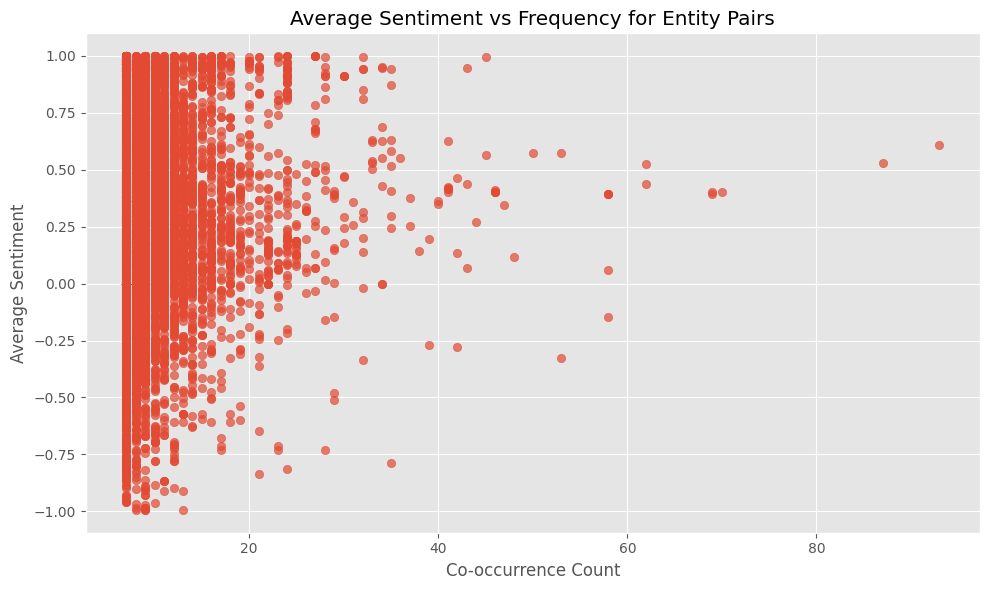

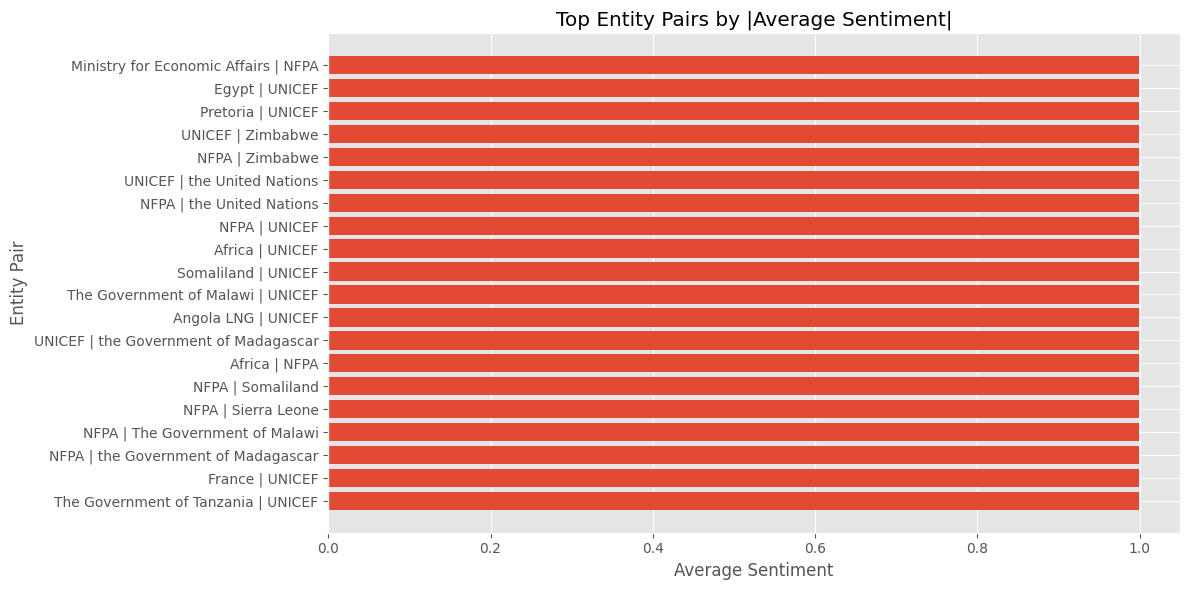

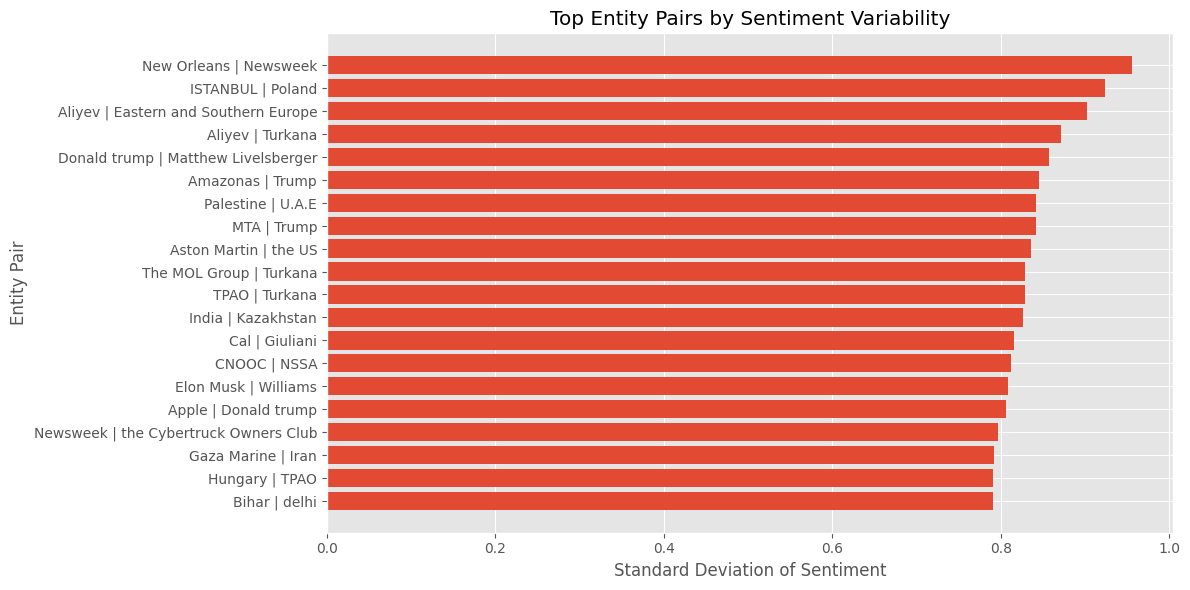

In [ ]:
## 10. Entity Pair Statistics (Using `entity_pairs_results.csv`)
#
# In this section, precomputed global statistics for each entity pair are analysed.
# The file `entity_pairs_results.csv` is assumed to contain, for each pair:
#   - entity_1, entity_2
#   - avg_sentiment       (mean VADER compound score)
#   - std_sentiment       (standard deviation of sentiment)
#   - co_occurrence       (overall co-occurrence weight across the corpus)
# Optional columns (e.g. n_sentences) may also be present.
# The most frequent pairs and those with extreme or highly variable sentiment
# values are visualised.

from pathlib import Path

entity_pairs_path = BASE_DIR / "entity_pairs_results.csv"
df_pairs = pd.read_csv(entity_pairs_path)

# A display label is created for each pair if it does not already exist.
if "pair" not in df_pairs.columns:
    if {"entity_1", "entity_2"}.issubset(df_pairs.columns):
        df_pairs["pair"] = df_pairs["entity_1"] + " | " + df_pairs["entity_2"]
    elif {"entity1", "entity2"}.issubset(df_pairs.columns):
        df_pairs["pair"] = df_pairs["entity1"] + " | " + df_pairs["entity2"]
    else:
        df_pairs["pair"] = df_pairs.index.astype(str)

# A unified 'count' column is ensured for plotting purposes.
if "co_occurrence" in df_pairs.columns:
    df_pairs["count"] = df_pairs["co_occurrence"]
elif "count" not in df_pairs.columns:
    raise ValueError("No 'co_occurrence' or 'count' column found in entity_pairs_results.csv.")

# ---- 10.1 Top 20 pairs by frequency ----------------------------------------
top_freq = df_pairs.nlargest(20, "count")

plt.figure(figsize=(12, 6))
plt.barh(top_freq["pair"], top_freq["count"])
plt.xlabel("Co-occurrence Count")
plt.ylabel("Entity Pair")
plt.title("Top Entity Pairs by Frequency")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# ---- 10.2 Sentiment vs frequency scatter -----------------------------------
plt.figure(figsize=(10, 6))
plt.scatter(df_pairs["count"], df_pairs["avg_sentiment"], alpha=0.7)
plt.xlabel("Co-occurrence Count")
plt.ylabel("Average Sentiment")
plt.title("Average Sentiment vs Frequency for Entity Pairs")
plt.tight_layout()
plt.show()

# ---- 10.3 Top 20 pairs by |average sentiment| ------------------------------
df_pairs["abs_avg_sent"] = df_pairs["avg_sentiment"].abs()
top_abs_sent = df_pairs.nlargest(20, "abs_avg_sent")

plt.figure(figsize=(12, 6))
plt.barh(top_abs_sent["pair"], top_abs_sent["avg_sentiment"])
plt.xlabel("Average Sentiment")
plt.ylabel("Entity Pair")
plt.title("Top Entity Pairs by |Average Sentiment|")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# ---- 10.4 Top 20 pairs by sentiment variability (std. deviation) -----------
if "std_sentiment" in df_pairs.columns:
    df_pairs["abs_std_sent"] = df_pairs["std_sentiment"].abs()
    top_std = df_pairs.nlargest(20, "abs_std_sent")

    plt.figure(figsize=(12, 6))
    plt.barh(top_std["pair"], top_std["std_sentiment"])
    plt.xlabel("Standard Deviation of Sentiment")
    plt.ylabel("Entity Pair")
    plt.title("Top Entity Pairs by Sentiment Variability")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
else:
    print("Column 'std_sentiment' not found; variability plot has been skipped.")


## Interpretation of Entity-Pair Statistics and Visualisations


This section evaluates global entity-pair statistics derived from entity_pairs_results.csv.
The figures summarise how often two entities appear together and the sentiment associated with their shared contexts.

1. Top Entity Pairs by Frequency

These bars show the 20 most frequently co-occurring entity pairs.

Key Insights

High-frequency pairs (e.g., Corporation | Placing, Sunita Williams’ | Sunita Williams’) arise from topic clusters, repeated article structures, or formulaic reporting.

Many correspond to political, organisational, or event-related entities that are consistently mentioned together.

Frequency reflects topic prominence, not sentiment.

Conclusion: These pairs mark the major recurring themes in the dataset.

2. Average Sentiment vs Frequency (Scatter Plot)

This figure plots pair frequency vs mean VADER sentiment.

Key Insights

Most pairs occur infrequently (left side of plot).

Sentiment values cover the full range
[
−
1
,
1
]
[−1,1].

There is no correlation between frequency and sentiment.

Conclusion: Co-occurrence captures how central a topic is, while sentiment reflects tone, and these two dimensions behave independently.

3. Pairs with Strongest |Average Sentiment|

These bars display the entity pairs with the most extreme sentiment values, ranked by absolute mean sentiment.

Key Insights

All pairs shown are strongly positive, near +1.

They mainly involve humanitarian or international cooperation entities (e.g., UNICEF, NFPA, government agencies).

No highly negative pairs appear because negative contexts are more dispersed, involving varied entities rather than recurring pairs.

Conclusion: The strongest sentiment signals come from positive, cooperative contexts.

4. Pairs with Highest Sentiment Variability

This plot highlights pairs with the largest standard deviation of sentiment.

Key Insights

High variability (> 0.8) indicates mixed or contradictory sentiment across articles.

These pairs often involve geopolitical actors, politicians, or controversial events—topics where reporting naturally fluctuates between positive and negative tones.

Conclusion: High-variability pairs reflect complex, contentious, or multi-faceted topics, such as political conflict or international negotiations.

Overall Summary (Short)

Frequency ≠ sentiment: topical prominence and emotional tone are independent.

Highly positive sentiment clusters around humanitarian and cooperative relationships.

Highly variable sentiment occurs in geopolitical or controversial contexts.

The dataset captures distinct patterns of topic importance, positive framing, and controversy, each revealed through entity-pair statistics.


## 11. Extended Text Preprocessing

News articles must be cleaned before word‑level or n‑gram analyses.  The function below expands contractions,
removes URLs and emails, strips non‑alphabetic characters, lowercases the text, tokenises it, removes stop words,
and optionally stems or lemmatises words.  A demonstration on a sample sentence is included.


In [ ]:
## 11. Extended Text Preprocessing (concise version)

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize

# NLTK resources needed for tokenisation and lemmatisation
for pkg in ["stopwords", "punkt", "punkt_tab", "wordnet", "omw-1.4"]:
    nltk.download(pkg, quiet=True)

# Reusable components
url_regex   = re.compile(r"https?://\S+|www\.\S+")
email_regex = re.compile(r"[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}")
stop_words  = set(stopwords.words("english"))
stemmer     = SnowballStemmer("english")
lemmatizer  = WordNetLemmatizer()

def uncontract(text: str) -> str:
    """Basic English contractions are expanded."""
    patterns = {
        r"can't": "cannot",
        r"n't": " not",
        r"'ll": " will",
        r"'ve": " have",
        r"'d": " would",
        r"'re": " are",
        r"'m": " am",
    }
    for pat, repl in patterns.items():
        text = re.sub(pat, repl, text)
    return text

def advanced_preprocess(text, stem: bool = False, lemmatize: bool = False) -> str:
    """
    News text is normalised: contractions expanded, URLs/emails removed,
    non-letters stripped, lowercased, tokenised, stop words removed,
    and optionally stemmed or lemmatised.
    """
    if not isinstance(text, str):
        text = ""

    text = uncontract(text)
    text = url_regex.sub(" URL ", text)
    text = email_regex.sub(" EMAIL ", text)
    text = re.sub(r"[^A-Za-z ]+", " ", text).lower()

    tokens = word_tokenize(text)
    cleaned = []
    for tok in tokens:
        if tok not in stop_words and len(tok) > 1:
            if lemmatize:
                tok = lemmatizer.lemmatize(tok)
            elif stem:
                tok = stemmer.stem(tok)
            cleaned.append(tok)

    return " ".join(cleaned)

# Quick demonstration
sample_text = (
    "Email me at example@example.com! Visit https://tesla.com for more info. "
    "I can't believe it's happening!"
)
print("Original:", sample_text)
print("Processed:", advanced_preprocess(sample_text, lemmatize=True))


Original: Email me at example@example.com! Visit https://tesla.com for more info. I can't believe it's happening!
Processed: email email visit url info believe happening
